In [ ]:
# import all the packages we need
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.nn import Sequential, Sigmoid, ReLU, Linear
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import confusion_matrix, plot_roc_curve, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from torch.utils.data import DataLoader, Dataset
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# upload the local file

from google.colab import files
uploaded = files.upload()

# data link: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction
import pandas as pd
import io
!pip install fsspec

# get train data set and validation data set
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')), index_col=0)
validation = train.sample(frac=0.33, random_state=2021)
train = train.drop(validation.index, axis=0)
# test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')), index_col=0)

Saving train.csv to train (3).csv


The ratio of the number of 1 response samples vs that of 0 response:{} 0.13917652254993376


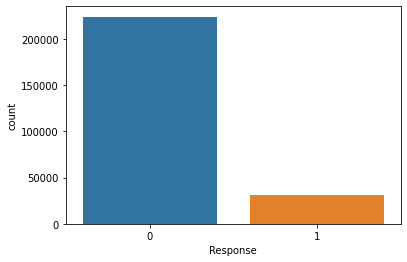

In [ ]:
# inner imbalance for the data set 
sns.countplot(train["Response"])
print("The ratio of the number of 1 response samples vs that of 0 response for train data set:{}",
      len(train.loc[train["Response"] == 1,]) / len(train.loc[train["Response"] == 0,]))

The ratio of the number of 1 response samples vs that of 0 response for validation data set:{} 0.14071400065304937


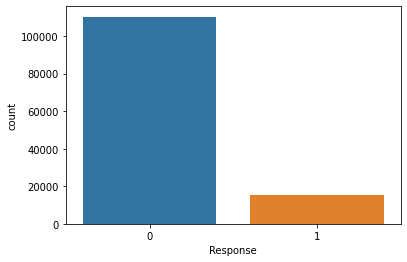

In [ ]:
sns.countplot(validation["Response"])
print("The ratio of the number of 1 response samples vs that of 0 response for validation data set:{}",
      len(validation.loc[validation["Response"] == 1,]) / len(validation.loc[validation["Response"] == 0,]))

In [ ]:
# the basic description of numeric features
numeric_predictors = ["Age", "Annual_Premium", "Vintage"]
train[numeric_predictors].describe()

,Age,Annual_Premium,Vintage
count,255343.00000,255343.000000,255343.000000
mean,38.83707,30547.839483,154.317228
std,15.52477,17155.991141,83.703273
min,20.00000,2630.000000,10.000000
25%,25.00000,24410.000000,82.000000
50%,36.00000,31661.000000,154.000000
75%,49.00000,39387.500000,227.000000
max,85.00000,540165.000000,299.000000


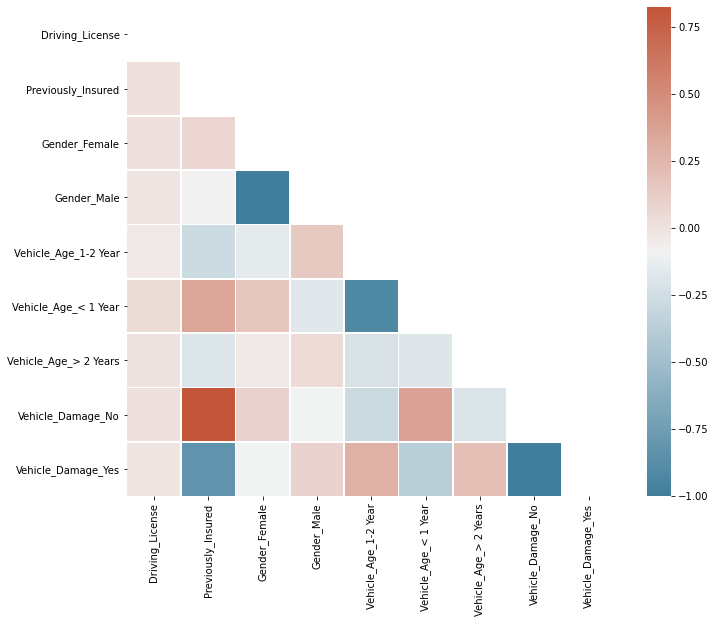

In [ ]:
# correlation for some categorical features
categorical_data = train.drop(numeric_predictors, axis=1)
categorical_data = categorical_data.drop(["Response", "Region_Code", "Policy_Sales_Channel"], axis=1)
categorical_data = pd.get_dummies(categorical_data)
corr = categorical_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5)

In [ ]:
# correlation for numeric features
numeric_data = train[numeric_predictors]
corr = numeric_data.corr()
print(corr)

                     Age  Annual_Premium   Vintage
Age             1.000000        0.064412 -0.000053
Annual_Premium  0.064412        1.000000 -0.001320
Vintage        -0.000053       -0.001320  1.000000


In [ ]:
# group on each feature to see their number of 1 responses, 0 responses and the ratio between 2 classes
def preprocess_level(data):
    try:
        data = data.assign(Driving_License=data["Driving_License"].astype(str))
    except:
        pass
    data = data.assign(Region_Code=data["Region_Code"].astype(str).str[:-2],
                       Previously_Insured=data["Previously_Insured"].astype(str),
                       Policy_Sales_Channel=data["Policy_Sales_Channel"].astype(str).str[:-2]
                       )
    data["Male"] = data["Gender"].map({"Male": 1, "Female": 0})
    data["Vehicle_Age"] = data["Vehicle_Age"].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
    data["Vehicle_Damage"] = data["Vehicle_Damage"].map({"Yes": 1, "No": 0})
    data = data.drop(["Gender"], axis=1)
    # divided quantitative predictors into 5 levels
    data = data.assign(Age=np.floor(data["Age"].rank(pct=True) / 0.2),
                       Annual_Premium=np.floor(data["Annual_Premium"].rank(pct=True) / 0.2),
                       Vintage=np.floor(data["Vintage"].rank(pct=True) / 0.2),
                       )

    return data

def visualization_group(data):
    response = pd.DataFrame(data["Response"], index=data.index, columns=["Response"])
    data = data.drop(["Response"], axis=1)
    for column in data.columns:
        visual_data = pd.DataFrame(data[column], index=data.index, columns=[column])
        visual_data = visual_data.merge(response, left_index=True, right_index=True)
        visual_data = visual_data.groupby([column]).agg(["mean", "sum", "count"])
        visual_data = visual_data.assign(ratioof1=visual_data[("Response", "mean")],
                                         amountof0=visual_data[("Response", "count")] - visual_data[
                                             ("Response", "sum")],
                                         amountof1=visual_data[("Response", "sum")]
                                         )
        visual_data = visual_data.drop([("Response", "mean"), ("Response", "count"), ("Response", "sum")], axis=1)
        print(visual_data.head())


visualization_group(preprocess_level(train))

     ratioof1 amountof0 amountof1
                                 
Age                              
0.0  0.035155     44022      1604
1.0  0.045836     55602      2671
2.0  0.200279     41340     10353
3.0  0.209235     38020     10060
4.0  0.125951     45163      6508
                 ratioof1 amountof0 amountof1
                                             
Driving_License                              
0                0.053860       527        30
1                0.122322    223620     31166
             ratioof1 amountof0 amountof1
                                         
Region_Code                              
0            0.089139      1216       119
1            0.105581       593        70
10           0.063582      2651       180
11           0.113265      5488       701
12           0.100968      1950       219
                    ratioof1 amountof0 amountof1
                                                
Previously_Insured                              
0              

In [ ]:
# We then can see that driving license is an insignificant feature, so we delete that column.
X = train.loc[train["Response"] == 1,]
r1 = len(X.loc[X["Driving_License"] == 1,]) / len(X)
r2 = len(X.loc[X["Previously_Insured"] == 0,]) / len(X)
r3 = len(X.loc[X["Vehicle_Damage"] == "Yes",]) / len(X)
print(
    "For 1-response samples, percentile of people having driving license: {}, having previous insurance: {}, having vehicle damaging: {}".format(
        r1, r2, r3))
X = train.loc[train["Response"] == 0,]
r1 = len(X.loc[X["Driving_License"] == 1,]) / len(X)
r2 = len(X.loc[X["Previously_Insured"] == 0,]) / len(X)
r3 = len(X.loc[X["Vehicle_Damage"] == "Yes",]) / len(X)
print(
    "For 0-response samples, percentile of people having driving license: {}, having previous insurance: {}, having vehicle damaging: {}".format(
        r1, r2, r3))



For 1-response samples, percentile of people having driving license: 0.9990383382484934, having previous insurance: 0.9966341838697269, having vehicle damaging: 0.980157712527247
For 0-response samples, percentile of people having driving license: 0.9976488643613343, having previous insurance: 0.4776240592111427, having vehicle damaging: 0.4386987111136888


In [ ]:
# We then can see that driving license is an insignificant feature, so we delete that column.


train = train.drop(["Driving_License"], axis=1)
validation = validation.drop(["Driving_License"], axis=1)

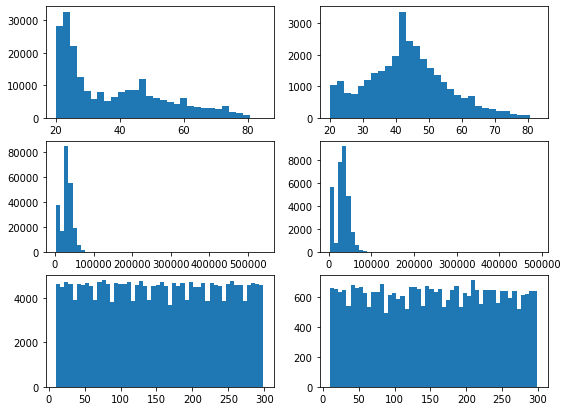

In [ ]:
# The distribution of numeric columns
def margin_dist(data):
  fig, axs = plt.subplots(3, 2, figsize=(9, 7))
  axs[0, 0].hist(x=data.loc[data["Response"] == 0, "Age"], bins=30)
  axs[0, 1].hist(x=data.loc[data["Response"] == 1, "Age"], bins=30)
  axs[1, 0].hist(x=data.loc[data["Response"] == 0, "Annual_Premium"], bins=50)
  axs[1, 1].hist(x=data.loc[data["Response"] == 1, "Annual_Premium"], bins=50)
  axs[2, 0].hist(x=data.loc[data["Response"] == 0, "Vintage"], bins=50)
  axs[2, 1].hist(x=data.loc[data["Response"] == 1, "Vintage"], bins=50)
  fig.show()


margin_dist(train)


In [ ]:
# 4 data argumentation methods, beta is the percentile of difference between two classes
# oversampling is our own defined oversampling methods
def oversampling(data, beta, features=["Age", "Annual_Premium", "Vintage"]):
    num_samples = int((len(data.loc[train["Response"] == 0,]) - len(data.loc[train["Response"] == 1,])) * beta)
    oversample_source = data.loc[train["Response"] == 1,].copy()
    oversamples = oversample_source.sample(n=num_samples, random_state=2021, replace=True)
    for feature in features:
        oversamples[feature] = (oversamples[feature] * (1 + np.random.uniform(-0.10, 0.10, size=num_samples))).astype(
            int)
    data = pd.concat([data, oversamples], ignore_index=True)
    data = shuffle(data, random_state=2021)
    data.reset_index(drop=True, inplace=True)
    return data

# we put all 4 methods together and call it random_sample function
def random_sample(data, method, ratio=None):
    response = data["Response"]
    features = data.drop(["Response"], axis=1)
    columns = features.columns
    features = features.assign(Age=features["Age"].astype(float),
                   Vintage=features["Vintage"].astype(float)
                   )
    if method == "random_oversample":
        model = RandomOverSampler(sampling_strategy=ratio, random_state=100)
        features, response = model.fit_resample(features, response)
    elif method == "SMOTE":
        model = RandomUnderSampler(sampling_strategy=0.5, random_state=100)
        features, response = model.fit_resample(features, response)
        model = SMOTENC(categorical_features=[0, 2, 3, 4, 5, 7], sampling_strategy=ratio, random_state=100)
        features, response = model.fit_resample(features, response)
    elif method == "oversampling":
        return oversampling(data, ratio)
    elif method == "random_undersample":
        model = RandomUnderSampler(sampling_strategy=ratio, random_state=100)
        features, response = model.fit_resample(features, response)
    features = pd.DataFrame(features, columns=columns)
    response = pd.DataFrame(response, columns=["Response"])
    data = shuffle(pd.concat([features, response], axis=1), random_state=100)
    data = data.reset_index(drop=True)
    data["Age"] = data["Age"].astype(float)
    data["Annual_Premium"] = data["Annual_Premium"].astype(float)
    data["Vintage"] = data["Vintage"].astype(float)
    return data


In [ ]:
# Forward variable selection
def forward(train, valid, method, dummy=False):
    train_y = train["Response"]
    train_x = train.drop(["Response"], axis=1)
    valid_y = valid["Response"]
    valid_x = valid.drop(["Response"], axis=1)

    left_predictors = train_x.columns.to_list()
    model_nums = len(left_predictors)
    chosen_predictors = []
    result = 0
    mtx = None
    features = None

    for i in range(model_nums):
        results = []
        for predictor in left_predictors:
            predictors = chosen_predictors + [predictor]
            if not dummy:
                train = train_x[predictors]
                valid = valid_x[predictors]
            else:
                train = pd.get_dummies(train_x[predictors])
                valid = pd.get_dummies(valid_x[predictors])
            model = method.fit(train, train_y)
            preds = model.predict(valid)
            score = f1_score(valid_y, preds)
            if score > result:
                result = score
                mtx = confusion_matrix(valid_y, preds)
                features = predictors.copy()
            results.append(score)

        choice = np.argmax(results)
        chosen_predictors.append(left_predictors[choice])
        left_predictors.remove(left_predictors[choice])
    return features, result, mtx

In [ ]:
# data preprocessing for Naive Bayes
def preprocess_bayes(data):
    try:
        data = data.assign(Driving_License=data["Driving_License"].astype(str))
    except:
        pass
    data = data.assign(Region_Code=data["Region_Code"].astype(str).str[:-2],
                       Previously_Insured=data["Previously_Insured"].astype(str),
                       Policy_Sales_Channel=data["Policy_Sales_Channel"].astype(str).str[:-2]
                       )
    data["Male"] = data["Gender"].map({"Male": 1, "Female": 0})
    data["Vehicle_Age"] = data["Vehicle_Age"].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
    data["Vehicle_Damage"] = data["Vehicle_Damage"].map({"Yes": 1, "No": 0})
    data = data.drop(["Gender"], axis=1)


    return data

In [ ]:
# data preprocessing for Logistic Regression
def preprocess_logistic(data):
    data = data.assign(
        Previously_Insured=data["Previously_Insured"].astype(str),
    )
    # standardize quantitative predictors
    scaled_data = pd.DataFrame(data[["Age", "Annual_Premium", "Vintage"]], columns=["Age", "Annual_Premium", "Vintage"])
    scaled_data = (scaled_data - scaled_data.mean()) / np.sqrt(scaled_data.var())
    data = data.assign(Age=scaled_data["Age"],
                       Annual_Premium=scaled_data["Annual_Premium"],
                       Vintage=scaled_data["Vintage"],
                       )
    data = data.copy()
    region_code = data.groupby(["Region_Code"]).agg("mean")["Response"]
    channel = data.groupby(["Policy_Sales_Channel"]).agg("mean")["Response"]
    region_code = np.floor((region_code.rank(pct=True) / 0.2))
    channel = np.floor(channel.rank(pct=True) / 0.2)
    region_code = dict(zip(region_code.index, region_code))
    channel = dict(zip(channel.index, channel))
    data["Region_Code"] = data["Region_Code"].map(region_code)
    data["Policy_Sales_Channel"] = data["Policy_Sales_Channel"].map(channel)
    data["Region_Code"] = data["Region_Code"].astype(str)
    data["Policy_Sales_Channel"] = data["Policy_Sales_Channel"].astype(str)
    data["Vehicle_Age"] = data["Vehicle_Age"].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype(str)
    return data


Best model's predictors are ['Vehicle_Damage', 'Age', 'Previously_Insured', 'Policy_Sales_Channel', 'Region_Code', 'Male']
Using random_oversample method, f1 score of train is :0.7645667374938129 for random_oversample method
Using random_oversample method, f1 score of valid is :0.43599525128611005 for random_oversample method
Best model's predictors are ['Vehicle_Damage', 'Age', 'Previously_Insured', 'Policy_Sales_Channel', 'Region_Code', 'Annual_Premium']
Using SMOTE method, f1 score of train is :0.7795895641107222 for SMOTE method
Using SMOTE method, f1 score of valid is :0.43829551743220807 for SMOTE method
Best model's predictors are ['Vehicle_Damage', 'Age', 'Policy_Sales_Channel', 'Previously_Insured', 'Annual_Premium', 'Region_Code', 'Male', 'Vintage']
Using oversampling method, f1 score of train is :0.7925496018356053 for oversampling method
Using oversampling method, f1 score of valid is :0.4391222274657858 for oversampling method
Best model's predictors are ['Vehicle_Damage',

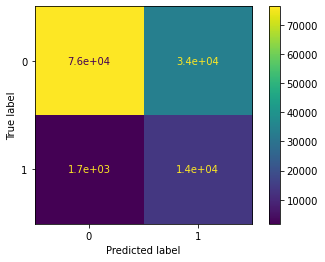

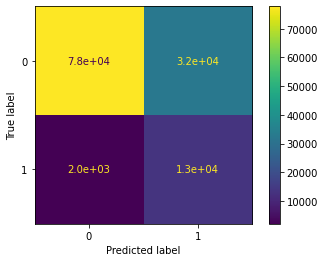

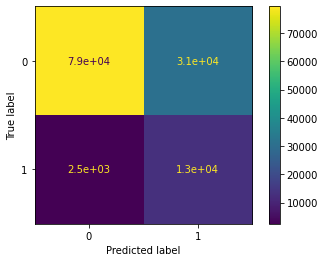

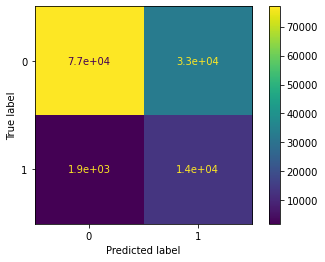

In [ ]:
# Naive Bayes

for method in ["random_oversample", "SMOTE", "oversampling","random_undersample"]:
  train_rs = random_sample(train, method=method, ratio=0.7)
  preprocess_trainrs = preprocess_bayes(train_rs)
  preprocess_validrs = preprocess_bayes(validation)
  model = CategoricalNB()
  chosen_predictors_B, score_B, mtx_B = forward(preprocess_trainrs, preprocess_validrs, model)
  model.fit(preprocess_trainrs[chosen_predictors_B], preprocess_trainrs["Response"])
  plot_confusion_matrix(model, preprocess_validrs[chosen_predictors_B], preprocess_validrs["Response"])
  train_preds = model.predict(preprocess_trainrs[chosen_predictors_B])
  val_preds = model.predict(preprocess_validrs[chosen_predictors_B])
  print("Best model's predictors are {}".format(chosen_predictors_B))
  print("Using {} method, f1 score of train is :{} for {} method".format(method, f1_score(preprocess_trainrs["Response"], train_preds), method))
  print("Using {} method, f1 score of valid is :{} for {} method".format(method, f1_score(preprocess_validrs["Response"], val_preds), method))



Best model's predictors are ['Vehicle_Damage', 'Policy_Sales_Channel', 'Previously_Insured', 'Age', 'Vehicle_Age', 'Annual_Premium', 'Gender', 'Vintage']
Using random_oversample method, f1 score of train is :0.7635242751968635 for random_oversample method
Using random_oversample method, f1 score of valid is :0.4425177565515552 for random_oversample method
Best model's predictors are ['Vehicle_Damage', 'Policy_Sales_Channel', 'Previously_Insured', 'Age', 'Region_Code', 'Annual_Premium']
Using SMOTE method, f1 score of train is :0.7680882323344134 for SMOTE method
Using SMOTE method, f1 score of valid is :0.444900457212802 for SMOTE method
Best model's predictors are ['Vehicle_Damage', 'Policy_Sales_Channel', 'Previously_Insured', 'Age', 'Vehicle_Age', 'Annual_Premium', 'Gender', 'Vintage']
Using oversampling method, f1 score of train is :0.7706979267501356 for oversampling method
Using oversampling method, f1 score of valid is :0.4429523606766782 for oversampling method
Best model's pre

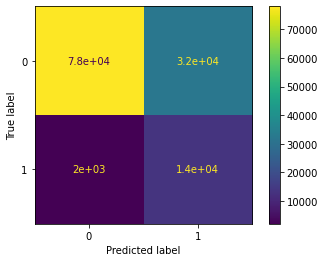

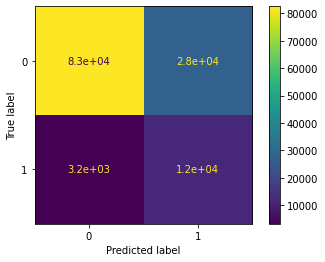

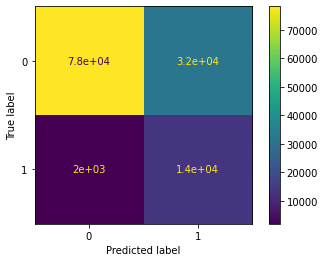

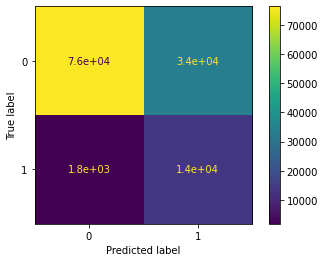

In [ ]:
# Logistic Regression

for method in ["random_oversample", "SMOTE", "oversampling", "random_undersample"]:
  train_rs = random_sample(train, method=method, ratio=0.7)
  preprocess_trainrs = preprocess_logistic(train_rs)
  preprocess_validrs = preprocess_logistic(validation)
  try:
    preprocess_trainrs = preprocess_trainrs.drop(preprocess_trainrs[preprocess_trainrs.loc[:, "Policy_Sales_Channel"] == "5.0"].index, axis=0)
  except:
      pass
  model = LogisticRegression(random_state=2021)
  chosen_predictors_L, score_L, mtx_L = forward(preprocess_trainrs, preprocess_validrs, model, dummy=True)
  model.fit(pd.get_dummies(preprocess_trainrs[chosen_predictors_L]), preprocess_trainrs["Response"])
  plot_confusion_matrix(model, pd.get_dummies(preprocess_validrs[chosen_predictors_L]), preprocess_validrs["Response"])
  train_preds = model.predict(pd.get_dummies(preprocess_trainrs[chosen_predictors_L]))
  val_preds = model.predict(pd.get_dummies(preprocess_validrs[chosen_predictors_L]))
  print("Best model's predictors are {}".format(chosen_predictors_L))
  print("Using {} method, f1 score of train is :{} for {} method".format(method, f1_score(preprocess_trainrs["Response"], train_preds), method))
  print("Using {} method, f1 score of valid is :{} for {} method".format(method, f1_score(preprocess_validrs["Response"], val_preds), method))



In [ ]:
# Random Forest data preprocessing
def preprocess_rf(data):
    # data = data.drop(["Gender", "Vehicle_Age",  "Vintage", "Region_Code"], axis=1)
    data = data.drop(["Gender", "Vehicle_Age",  "Vintage"], axis=1)
    data = data.assign(
        Previously_Insured=data["Previously_Insured"].astype(str),
    )
    scaled_data = pd.DataFrame(data[["Age", "Annual_Premium"]], columns=["Age", "Annual_Premium"])
    scaled_data = (scaled_data - scaled_data.mean()) / np.sqrt(scaled_data.var())
    data = data.assign(Age=scaled_data["Age"],
                       Annual_Premium = scaled_data["Annual_Premium"])
    data = data.copy()
    region_code = data.groupby(["Region_Code"]).agg("mean")["Response"]
    channel = data.groupby(["Policy_Sales_Channel"]).agg("mean")["Response"]
    region_code = np.floor((region_code.rank(pct=True) / 0.2))
    channel = np.floor(channel.rank(pct=True) / 0.2)
    region_code = dict(zip(region_code.index, region_code))
    channel = dict(zip(channel.index, channel))
    data["Region_Code"] = data["Region_Code"].map(region_code)
    data["Policy_Sales_Channel"] = data["Policy_Sales_Channel"].map(channel)
    data["Region_Code"] = data["Region_Code"].astype(str)
    data["Policy_Sales_Channel"] = data["Policy_Sales_Channel"].astype(str)
    return data

In [ ]:
# A method containing parameters tuning for random forest and boosting
def tree_methods(train, valid, para1, para2, boost=False):

    train_y = train["Response"]
    valid_y = valid["Response"]
    train_x = train.drop(["Response"], axis=1)
    valid_x = valid.drop(["Response"], axis=1)
    best_model = None
    f1score = 0

    val_f1scores = pd.DataFrame(np.zeros(shape=(len(para1), len(para2))), columns=para2,
                                index=para1).rename_axis("para1", axis=0).rename_axis("para2", axis=1)
    train_f1scores = pd.DataFrame(np.zeros(shape=(len(para1), len(para2))), columns=para2,
                                  index=para1).rename_axis("para1", axis=0).rename_axis("para2", axis=1)
    for i in range(len(para1)):
        first = para1[i]
        for j in range(len(para2)):
            n = para2[j]
            if not boost:
                parameters = {'max_depth': first, 'n_estimators': n, 'random_state': 201, 'max_features': "sqrt"}
                model = RandomForestClassifier(**parameters)
            if boost:
                parameters = {'learning_rate': first, 'n_estimators': n, 'random_state': 201,
                              'max_features': "sqrt"}
                model = GradientBoostingClassifier(**parameters)
            model.fit(train_x, train_y)
            train_preds = model.predict(train_x)
            val_preds = model.predict(valid_x)
            train_score = f1_score(train_y, train_preds)
            train_f1scores.iloc[i, j] = train_score
            val_score = f1_score(valid_y, val_preds)
            val_f1scores.iloc[i, j] = val_score

            if val_score > f1score:
                best_model = model
                f1score = val_score
    plot_confusion_matrix(best_model, valid_x, valid_y)
    plot_roc_curve(best_model, valid_x, valid_y)
    columns = train_x.columns
    try:
      importances = pd.DataFrame(best_model.feature_importances_, index=columns)
    except:
      importances = pd.DataFrame(best_model.feature_importances_, columns=columns)
    print(importances)
    return train_f1scores, val_f1scores


In [ ]:
# data preprocessing for later methods
train_rs = random_sample(train, method="SMOTE", ratio=0.7)
preprocess_trainrs = preprocess_rf(train_rs)
preprocess_validrs = preprocess_rf(validation)
try:
    preprocess_trainrs = preprocess_trainrs.drop(
        preprocess_trainrs[preprocess_trainrs.loc[:, "Policy_Sales_Channel"] == "5.0"].index, axis=0)
except:
    pass


                                 0
Age                       0.076620
Annual_Premium            0.012725
Region_Code_0.0           0.003370
Region_Code_1.0           0.003851
Region_Code_2.0           0.001380
Region_Code_3.0           0.000813
Region_Code_4.0           0.002755
Region_Code_5.0           0.014269
Previously_Insured_0      0.149610
Previously_Insured_1      0.127759
Vehicle_Damage_No         0.243062
Vehicle_Damage_Yes        0.240872
Policy_Sales_Channel_0.0  0.000237
Policy_Sales_Channel_1.0  0.068545
Policy_Sales_Channel_2.0  0.001842
Policy_Sales_Channel_3.0  0.002288
Policy_Sales_Channel_4.0  0.050001
para2      500       1000
para1                    
3      0.771083  0.770901
5      0.772357  0.772205
7      0.775926  0.776060
9      0.779599  0.779598
11     0.786674  0.786727
para2      500       1000
para1                    
3      0.435056  0.435056
5      0.436713  0.436858
7      0.443908  0.444232
9      0.443972  0.444411
11     0.435563  0.434319


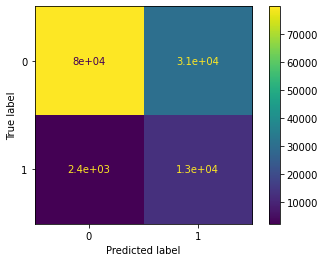

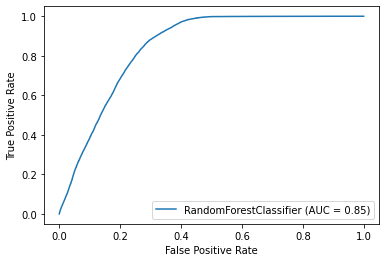

In [ ]:
# Random Forest
train_f1scores, val_f1scores = tree_methods(pd.get_dummies(preprocess_trainrs), pd.get_dummies(preprocess_validrs), [3, 5, 7, 9, 11], [500, 1000])
print(train_f1scores)
print(val_f1scores)



                                 0
Age                       0.074897
Annual_Premium            0.001749
Region_Code_0.0           0.004161
Region_Code_1.0           0.004246
Region_Code_2.0           0.000765
Region_Code_3.0           0.000085
Region_Code_4.0           0.002317
Region_Code_5.0           0.014605
Previously_Insured_0      0.179180
Previously_Insured_1      0.108239
Vehicle_Damage_No         0.222118
Vehicle_Damage_Yes        0.265439
Policy_Sales_Channel_0.0  0.000157
Policy_Sales_Channel_1.0  0.066953
Policy_Sales_Channel_2.0  0.000629
Policy_Sales_Channel_3.0  0.000500
Policy_Sales_Channel_4.0  0.053958
para2      300       500       1000
para1                              
0.10   0.776288  0.778222  0.782238
0.05   0.774049  0.776617  0.778777
0.01   0.771921  0.773459  0.773878
para2      300       500       1000
para1                              
0.10   0.442619  0.438045  0.419285
0.05   0.446775  0.440848  0.436863
0.01   0.445110  0.448629  0.446885


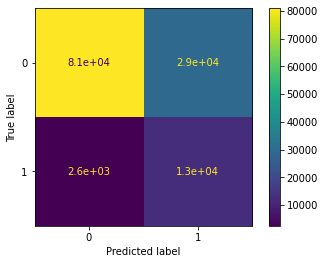

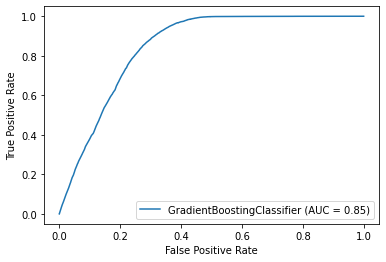

In [ ]:
# gradient boosting method
train_f1scores, val_f1scores = tree_methods(pd.get_dummies(preprocess_trainrs), pd.get_dummies(preprocess_validrs), [0.1, 0.05, 0.01], [300, 500, 1000], boost=True)
print(train_f1scores)
print(val_f1scores)

In [ ]:
# Due to feature importance, we delete annual premium and region code.


preprocess_trainrs = pd.get_dummies(preprocess_trainrs.drop(["Annual_Premium", "Region_Code"], axis=1))
preprocess_validrs = pd.get_dummies(preprocess_validrs.drop(["Annual_Premium", "Region_Code"], axis=1))


                                 0
Age                       0.060348
Previously_Insured_0      0.157020
Previously_Insured_1      0.150098
Vehicle_Damage_No         0.258379
Vehicle_Damage_Yes        0.249860
Policy_Sales_Channel_0.0  0.000179
Policy_Sales_Channel_1.0  0.071347
Policy_Sales_Channel_2.0  0.001554
Policy_Sales_Channel_3.0  0.002061
Policy_Sales_Channel_4.0  0.049154
para2      500       1000
para1                    
3      0.770182  0.770159
5      0.770902  0.770667
7      0.774440  0.774465
9      0.780618  0.780618
11     0.781497  0.781485
para2      500       1000
para1                    
3      0.435070  0.435070
5      0.442664  0.442951
7      0.420449  0.420449
9      0.408702  0.408700
11     0.399361  0.399596


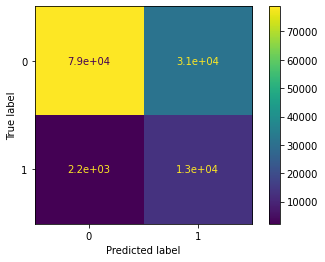

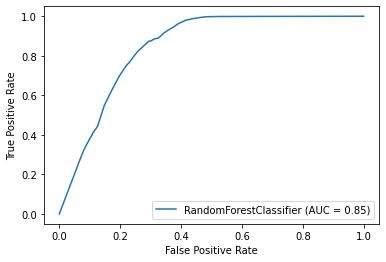

In [ ]:
# random forest
train_f1scores, val_f1scores = tree_methods(pd.get_dummies(preprocess_trainrs), pd.get_dummies(preprocess_validrs), [3, 5, 7, 9, 11], [500, 1000])
print(train_f1scores)
print(val_f1scores)


                                 0
Age                       0.088436
Previously_Insured_0      0.140074
Previously_Insured_1      0.144000
Vehicle_Damage_No         0.302880
Vehicle_Damage_Yes        0.191741
Policy_Sales_Channel_0.0  0.000538
Policy_Sales_Channel_1.0  0.071164
Policy_Sales_Channel_2.0  0.001750
Policy_Sales_Channel_3.0  0.001146
Policy_Sales_Channel_4.0  0.058271
para2      500       1000      1500
para1                              
0.10   0.779096  0.780204  0.781061
0.05   0.775439  0.779210  0.779666
0.01   0.769860  0.769278  0.773451
para2      500       1000      1500
para1                              
0.10   0.410346  0.402491  0.394707
0.05   0.428120  0.408282  0.407159
0.01   0.446714  0.446932  0.439385


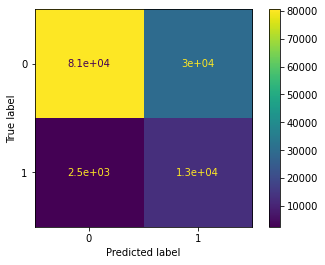

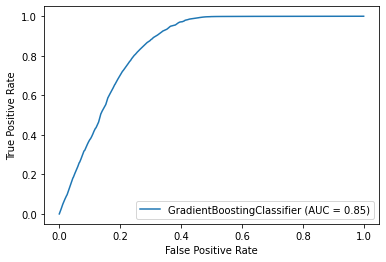

In [ ]:
# gradient boosting tree
train_f1scores, val_f1scores = tree_methods(pd.get_dummies(preprocess_trainrs), pd.get_dummies(preprocess_validrs), [0.1, 0.05, 0.01], [500, 1000, 1500], boost=True)
print(train_f1scores)
print(val_f1scores)

In [ ]:
# SVM 
def train_svm(preprocess_trainrs, preprocess_validrs, cs):
  f1s = pd.DataFrame(np.zeros(shape=(len(cs), 2)), index=cs, columns=["f1 for train", "f1 for valid"])
  for i in range(len(cs)):
    c = cs[i]
    model = LinearSVC(class_weight='balanced', random_state=2021, penalty='l1', dual=False, C=c)
    model.fit(pd.get_dummies(preprocess_trainrs).drop(["Response"], axis=1), preprocess_trainrs["Response"])
    # plot_confusion_matrix(model, pd.get_dummies(preprocess_validrs.drop(["Response"], axis=1)), preprocess_validrs["Response"])
    # plot_roc_curve(model, pd.get_dummies(preprocess_validrs.drop(["Response"], axis=1)), preprocess_validrs["Response"])  
    f1s.iloc[i, 0] = f1_score(preprocess_trainrs["Response"], model.predict(pd.get_dummies(preprocess_trainrs.drop(["Response"], axis=1))))
    f1s.iloc[i, 1] = f1_score(preprocess_validrs["Response"], model.predict(pd.get_dummies(preprocess_validrs.drop(["Response"], axis=1))))
  return f1s

In [ ]:
f1s = train_svm(preprocess_trainrs, preprocess_validrs, [0.01, 0.02, 0.05, 0.1, 0.2])
print(f1s)

      f1 for train  f1 for valid
0.01      0.767940      0.435943
0.02      0.768051      0.436115
0.05      0.768197      0.436753
0.10      0.768197      0.436772
0.20      0.768197      0.436753


In [ ]:
# preparing the data set for neural network
def preprocess_neural(preprocess_trainrs, preprocess_validrs):

  train_y = np.array(preprocess_trainrs["Response"], dtype=float).reshape(-1, 1)
  train_x = np.array(preprocess_trainrs.drop(["Response"], axis=1), dtype=float)
  valid_y = np.array(preprocess_validrs["Response"], dtype=float).reshape(-1, 1)
  valid_x = np.array(preprocess_validrs.drop(["Response"], axis=1), dtype=float)
  train_data = MyData(train_x, train_y)
  valid_data = MyData(valid_x, valid_y)
  dl_train = DataLoader(train_data, batch_size=32)
  dl_valid = DataLoader(valid_data, batch_size=len(valid_data))
  X_val, y_val = next(dl_valid.__iter__())
  y_val = y_val.reshape((-1, 1)).float()
  return dl_train, X_val, y_val
class MyData(Dataset):

  def __init__(self, features, response):
    self.features = features
    self.response = response

  def __getitem__(self, index):
    return self.features[index], self.response[index]

  def __len__(self):
    return len(self.response)


In [ ]:
# define two ways to compute the results
def compute_f1(preds, truth):

    preds = preds.detach()
    tp = (truth * preds).sum().to(torch.float32)
    tn = ((1 - truth) * (1 - preds)).sum().to(torch.float32)
    fp = ((1 - truth) * preds).sum().to(torch.float32)
    fn = (truth * (1 - preds)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)

    return f1_score

def compute_acc(preds, truth):
  preds = preds.detach()
  return torch.mean(1.0 * (preds == truth))

In [ ]:

def train_neural(Model, k, dl_train, X_val, y_val):
  lr = 0.01
  opt = torch.optim.SGD(Model.parameters(), lr=lr)
  for epoch in range(k):
    losses = []
    f1s = []
    accs = []
    accs_val = []
    losses_val = []
    f1s_val = []
    Model.train()
    for X, y in dl_train:
      X = X.float()
      y = y.reshape(-1, 1).float()
      yy = Model(X)
      loss = torch.nn.functional.binary_cross_entropy(yy, y)
      losses.append(loss.item())
      loss.backward()
      opt.step()
      opt.zero_grad()
      f1 = compute_f1(torch.round(yy), y)
      f1s.append(f1.item())
      acc = compute_acc(torch.round(yy), y)
      accs.append(acc.item())
    Model.eval()
    with torch.no_grad():
      X_val = X_val.float()
      y_val = y_val.reshape(-1, 1).float()
      yy_val = Model(X_val)
      loss_val = torch.nn.functional.binary_cross_entropy(yy_val, y_val)
      losses_val.append(loss_val.item())
      f1_val = compute_f1(torch.round(yy_val), y_val)
      f1s_val.append(f1_val.item())
      acc = compute_acc(torch.round(yy_val), y_val)
      accs_val.append(acc.item())
    print("Epoch: {}, t-loss: {}, t-acc: {}, t-f1: {}, v-loss: {}, v-acc: {}, v-f1: {}".format(epoch, np.mean(losses), np.mean(accs), np.mean(f1s), np.mean(losses_val), np.mean(accs_val), np.mean(f1s_val)))
      


In [ ]:
dl_train , X_val, y_val = preprocess_neural(preprocess_trainrs, preprocess_validrs)

In [ ]:
# train the neural network
Model = Sequential(
    Linear(10, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 1),
    Sigmoid()   
)
train_neural(Model, 10, dl_train, X_val, y_val)

Epoch: 0, t-loss: 0.4599003423437993, t-acc: 0.763606083465018, t-f1: 0.6853294959187867, v-loss: 0.3839508891105652, v-acc: 0.7440723180770874, v-f1: 0.44618797302246094
Epoch: 1, t-loss: 0.4221225898145371, t-acc: 0.7855140774318355, t-f1: 0.761235760311915, v-loss: 0.3860185742378235, v-acc: 0.745948851108551, v-f1: 0.44762545824050903
Epoch: 2, t-loss: 0.4209395559440012, t-acc: 0.7857214680804027, t-f1: 0.760644089438437, v-loss: 0.3872320055961609, v-acc: 0.7464179396629333, v-f1: 0.4476810395717621
Epoch: 3, t-loss: 0.42044915561402724, t-acc: 0.7857874560140377, t-f1: 0.760501483824458, v-loss: 0.3879322409629822, v-acc: 0.7467042207717896, v-f1: 0.4478071928024292
Epoch: 4, t-loss: 0.42011052090927486, t-acc: 0.7858628707953348, t-f1: 0.7607990081134065, v-loss: 0.38837337493896484, v-acc: 0.747833251953125, v-f1: 0.4480297565460205
Epoch: 5, t-loss: 0.41983642153340767, t-acc: 0.7858440171000105, t-f1: 0.7611164035210962, v-loss: 0.38876551389694214, v-acc: 0.747833251953125,

In [ ]:
# adding width
Model = Sequential(
    Linear(10, 128),
    ReLU(),
    Linear(128, 64),
    ReLU(),
    Linear(64, 1),
    Sigmoid()   
)
train_neural(Model, 5, dl_train, X_val, y_val)

Epoch: 0, t-loss: 0.4510212622526724, t-acc: 0.7700257667229367, t-f1: 0.7070939433048753, v-loss: 0.3848501443862915, v-acc: 0.7487715482711792, v-f1: 0.4482974410057068
Epoch: 1, t-loss: 0.42124964429871886, t-acc: 0.7858157365570241, t-f1: 0.7606745833994576, v-loss: 0.38743433356285095, v-acc: 0.7462112307548523, v-f1: 0.4475942552089691
Epoch: 2, t-loss: 0.42030997642204954, t-acc: 0.7859759929672805, t-f1: 0.761315770152827, v-loss: 0.3875357210636139, v-acc: 0.7465054392814636, v-f1: 0.4476706385612488
Epoch: 3, t-loss: 0.4198258473143139, t-acc: 0.7860514077485776, t-f1: 0.761981872942293, v-loss: 0.38771146535873413, v-acc: 0.7465292811393738, v-f1: 0.44767478108406067
Epoch: 4, t-loss: 0.4195037227275684, t-acc: 0.7861173956822126, t-f1: 0.7625433007786176, v-loss: 0.3882271647453308, v-acc: 0.7431579232215881, v-f1: 0.4466371536254883


In [ ]:
# adding depth
Model = Sequential(
    Linear(10, 64),
    ReLU(),
    Linear(64, 32),
    ReLU(),
    Linear(32, 16),
    ReLU(),
    Linear(16, 1),
    Sigmoid()   
)
train_neural(Model, 5, dl_train, X_val, y_val)

Epoch: 0, t-loss: 0.504324592445411, t-acc: 0.725106837612831, t-f1: 0.5309021645721447, v-loss: 0.3916008770465851, v-acc: 0.7510455846786499, v-f1: 0.4495621919631958
Epoch: 1, t-loss: 0.4210599837260009, t-acc: 0.7859477124242941, t-f1: 0.7601232784096472, v-loss: 0.39361336827278137, v-acc: 0.7485806941986084, v-f1: 0.44853320717811584
Epoch: 2, t-loss: 0.4201672185734926, t-acc: 0.7860325540532533, t-f1: 0.760959600035781, v-loss: 0.39357659220695496, v-acc: 0.745265007019043, v-f1: 0.44717079401016235
Epoch: 3, t-loss: 0.4197263450734036, t-acc: 0.7862022373111719, t-f1: 0.7619198783670256, v-loss: 0.3933280408382416, v-acc: 0.742919385433197, v-f1: 0.4469001889228821
Epoch: 4, t-loss: 0.4194308497202702, t-acc: 0.7860891151392262, t-f1: 0.7624929788335596, v-loss: 0.39264753460884094, v-acc: 0.7403113842010498, v-f1: 0.4463655650615692


In [ ]:
# Using data cleaning methods for imbalance data, and check its performance
# cleaning = EditedNearestNeighbours(sampling_strategy="all")
# X = pd.get_dummies(preprocess_trainrs).drop(["Response"], axis=1)
# y = preprocess_trainrs["Response"]
# columns = X.columns
# X, y = cleaning.fit_resample(X, y)
# X = pd.DataFrame(X, columns=columns)
# y = pd.DataFrame(y, columns=["Response"])
# cleaning_trainrs = pd.concat([X, y], axis=1)
# cleaning_trainrs = cleaning_trainrs.reset_index(drop=True)



In [ ]:
# dl_train_clean , X_val_clean, y_val_clean = preprocess_neural(cleaning_trainrs, preprocess_validrs)


In [ ]:
# Model = Sequential(
#     Linear(10, 64),
#     ReLU(),
#     Linear(64, 32),
#     ReLU(),
#     Linear(32, 1),
#     Sigmoid()   
# ).to("cuda")
# fit(Model, 10, dl_train_clean, X_val_clean, y_val_clean)

Epoch: 0, t-loss: 0.13165316080443343, t-acc: 0.9587350624660511, t-f1: 0.2875159981780438, v-loss: 2.079071283340454, v-acc: 0.3536567986011505, v-f1: 0.2761531174182892
Epoch: 1, t-loss: 0.0451426678515479, t-acc: 0.9857414448669202, t-f1: 0.3208130738581088, v-loss: 1.7838655710220337, v-acc: 0.5926244258880615, v-f1: 0.3749511241912842
Epoch: 2, t-loss: 0.03261357303538769, t-acc: 0.9893060836501901, t-f1: 0.32233944773220746, v-loss: 1.812914490699768, v-acc: 0.6121368408203125, v-f1: 0.3851621747016907
Epoch: 3, t-loss: 0.028707433619369376, t-acc: 0.9903415263443781, t-f1: 0.32275475661175723, v-loss: 1.847131609916687, v-acc: 0.6167804002761841, v-f1: 0.3879406452178955
Epoch: 4, t-loss: 0.0265307891548328, t-acc: 0.9912072243346007, t-f1: 0.32303829224034536, v-loss: 1.8767189979553223, v-acc: 0.6189351677894592, v-f1: 0.3892025351524353
Epoch: 5, t-loss: 0.025013346332010675, t-acc: 0.9918862031504617, t-f1: 0.3233049489246122, v-loss: 1.9037834405899048, v-acc: 0.62167042493